# <center> Train XGBoost classifier </center>

In [25]:
import gensim
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint, uniform
from sklearn import cross_validation, metrics
from sklearn.model_selection import RandomizedSearchCV
from capstone_project import preprocessor as pre

%matplotlib inline

In [2]:
file_directory = "../output/data/"

train_data = pre.load_pickle(file_directory, "train_features.pkl")
train_y = pre.load_pickle(file_directory, "train_labels.pkl")

In [21]:
def fit_model(alg, x_train, y_train, use_cv=True, cv_folds=5, early_stopping_rounds=50):
    """https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/"""
    if use_cv:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        #xgtest = xgb.DMatrix(x_test)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='logloss', early_stopping_rounds=early_stopping_rounds, stratified=True)
        print("\nBest number of iterations: {}\n".format(cvresult.shape[0]))
        print(cvresult[-10:])
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='logloss')

    # Predict training set:
    train_predictions = alg.predict(x_train)
    train_predprob = alg.predict_proba(x_train)[:, 1]

    # Print model report:
    print("\nModel Report on full training set")
    print("Accuracy : {:.4g}".format(metrics.accuracy_score(y_train, train_predictions)))
    print("Logloss (Train): {}".format(metrics.log_loss(y_train, train_predprob)))

    feat_importance = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_importance.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


In [4]:
#http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Define inital parameters for XGBoost Classifier:

In [5]:
learning_rate = 0.2
n_estimators = 1000
max_depth = 10
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
objective = "binary:logistic"
nthread = 4
scale_pos_weight = 1
reg_alpha=0
seed = 3453

Find best number of estimators for a high learnng rate:


Best number of iterations: 367

     test-logloss-mean  test-logloss-std  train-logloss-mean  \
357           0.419642          0.001342            0.217457   
358           0.419623          0.001369            0.217163   
359           0.419606          0.001374            0.216754   
360           0.419598          0.001357            0.216357   
361           0.419575          0.001343            0.216047   
362           0.419570          0.001314            0.215732   
363           0.419582          0.001287            0.215382   
364           0.419562          0.001293            0.214934   
365           0.419560          0.001282            0.214523   
366           0.419547          0.001290            0.214143   

     train-logloss-std  
357           0.001509  
358           0.001460  
359           0.001499  
360           0.001446  
361           0.001470  
362           0.001426  
363           0.001301  
364           0.001263  
365           0.001424  
366         

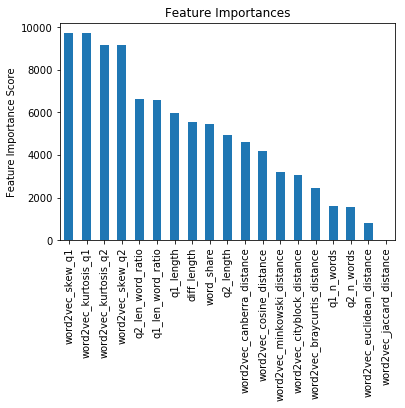

In [4]:
clf = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                         min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                         colsample_bytree=colsample_bytree, objective=objective, nthread=nthread,
                         scale_pos_weight=scale_pos_weight, reg_alpha=reg_alpha, seed=seed)

fit_model(clf, train_data, train_y)

In [6]:
n_estimators = 367

In [22]:
param_dist = {"max_depth": randint(6,16), #randint takes min and max values as parameters
              "min_child_weight": randint(1,6)}

n_iter_search = 10  # Number of searches in Randomized search

random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=n_thread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

start = time()
random_search.fit(train_data, train_y)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
report(random_search.cv_results_)  

RandomizedSearchCV took 89.54 seconds for 10 candidates parameter settings.


NameError: name 'random_search' is not defined

In [25]:
report(random_search_1.cv_results_)  

Model with rank: 1
Mean validation score: -0.419 (std: 0.002)
Parameters: {'max_depth': 10, 'min_child_weight': 1}

Model with rank: 2
Mean validation score: -0.420 (std: 0.001)
Parameters: {'max_depth': 10, 'min_child_weight': 4}

Model with rank: 3
Mean validation score: -0.420 (std: 0.002)
Parameters: {'max_depth': 11, 'min_child_weight': 3}



In [7]:
# Best model score 0.419
max_depth = 10
min_child_weight = 1

In [26]:
param_dist = {"gamma": uniform(0, 0.5)}

n_iter_search = 5  # Number of searches in Randomized search


random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=n_thread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_y)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
report(random_search.cv_results_)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=367, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.8),
          fit_params={}, iid=False, n_iter=5, n_jobs=2,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6a7940f610>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)
RandomizedSearchCV took 32.80 minutes for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.419 (std: 0.001)
Parameters: {'gamma': 0.489309171116382}

Model with rank: 2
Mean validation score: -0.419 (std: 0.001)
Parameters: {'gamma': 0.05913721293446661}

Mode

In [8]:
# no Improvement visible keep gamma
gamma = 0

In [12]:
param_dist = {"subsample": uniform (0.5, 0.4),  # Uniform takes minimum value and range as parameters
              "colsample_bytree": uniform (0.5, 0.4)}

n_iter_search = 8  # Number of searches in Randomized search


random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=nthread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_y)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
report(random_search.cv_results_)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=367, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.8),
          fit_params={}, iid=False, n_iter=8, n_jobs=2,
          param_distributions={'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1d21d31f90>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1d21d31c10>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)
RandomizedSearchCV took 40.42 minutes for 8 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.417 (std: 0.002)
Parameters: {'subsample': 0.85397536224441539, 'colsample

In [13]:
# loss is 0.417
subsample = 0.854 
colsample_bytree = 0.722

In [14]:
param_dist = { 'reg_alpha': uniform(0,100)} # Uniform takes minimum value and range as parameters
n_iter_search = 10  # Number of searches in Randomized search

random_search = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                               max_depth=max_depth, min_child_weight=min_child_weight, 
                                                               gamma=gamma, subsample=subsample, 
                                                               colsample_bytree=colsample_bytree, objective=objective, 
                                                               nthread=nthread, scale_pos_weight=scale_pos_weight, 
                                                                reg_alpha=reg_alpha, seed=seed), 
                                 param_distributions = param_dist, n_iter=n_iter_search, 
                                 scoring='neg_log_loss', n_jobs=2, iid=False, cv=5, random_state=329)

print random_search
start = time()
random_search.fit(train_data, train_y)
print "\nRandomizedSearchCV took {:.2f} minutes for {} candidates parameter settings.".format((time() - start)/60, n_iter_search)
report(random_search.cv_results_)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.722,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=367, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.854),
          fit_params={}, iid=False, n_iter=10, n_jobs=2,
          param_distributions={'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1d21d11a10>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)
RandomizedSearchCV took 49.90 minutes for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.419 (std: 0.002)
Parameters: {'reg_alpha': 7.0631346299201319}

Model with rank: 2
Mean validation score: -0.424 (std: 0.001)
Parameters: {'reg_alpha': 24.40086

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.722,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=367, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.854),
          fit_params={}, iid=False, n_iter=4, n_jobs=2,
          param_distributions={'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1d21d9cad0>},
          pre_dispatch='2*n_jobs', random_state=329, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=0)

RandomizedSearchCV took 22.29 minutes for 4 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.415 (std: 0.001)
Parameters: {'reg_alpha': 0.78193923379878716}

Model with rank: 2
Mean validation score: -0.416 (std: 0.002)
Parameters: {'reg_alpha': 1.717317

In [33]:
#best model 0.415
reg_alpha = 0.782
learning_rate = 0.01
n_estimators = 50000

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.722,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=50000, nthread=4,
       objective='binary:logistic', reg_alpha=0.782, reg_lambda=1,
       scale_pos_weight=1, seed=3453, silent=True, subsample=0.854)

Best number of iterations: 11799

       test-logloss-mean  test-logloss-std  train-logloss-mean  \
11789           0.396335          0.001325            0.152488   
11790           0.396335          0.001326            0.152480   
11791           0.396334          0.001326            0.152472   
11792           0.396332          0.001327            0.152463   
11793           0.396331          0.001325            0.152452   
11794           0.396331          0.001325            0.152437   
11795           0.396331          0.001325            0.152429   
11796           0.396331          0.001325            0.152416   
11797           0.396

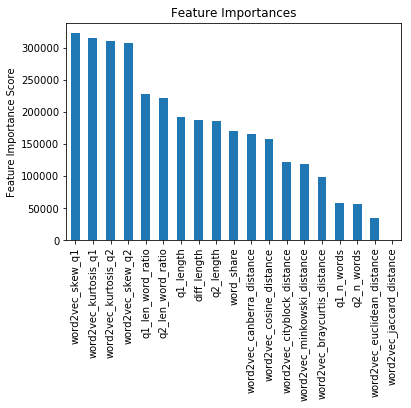


XGB fitting took 220.18 minutes.


In [34]:
clf = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                         min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                         colsample_bytree=colsample_bytree, objective=objective, nthread=nthread,
                         scale_pos_weight=scale_pos_weight, reg_alpha=reg_alpha, seed=seed)

print clf
start = time()
fit_model(clf, train_data, train_y)
print "\nXGB fitting took {:.2f} minutes.".format((time() - start)/60)


In [35]:
model_directory = "../output/models/"
prefix = "first_test_"

pre.save_pickle(clf, model_directory, prefix+"xgboost.pkl") 